In [1]:
from wasserstein.texture_mixing_new import compute_texture_mixing, compute_optimal_transport_barycenter, compute_optimal_assignment, build_pyramid,compute_optimal_transport, pyramid_projection, build_pyramid_barycenters
from utils.image_treatment import preprocess_image
import numpy as np
import pyrtools as pt
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [2]:
image_path1 = 'data/161.gif'
image_path2 = 'data/Water.jpg'

image1 = preprocess_image(image_path1, new_size = (200,200))
image2 = preprocess_image(image_path2, new_size = (200,200))
rho = [1, 0]
textures = [image1, image2]

In [2]:
def compute_optimal_transport_barycenter_with_regularization(
    X_ini, lambdas, point_clouds, iterations=10, projections=20, regularization_weight=0.01, return_asg=False
):
    """
    Compute the optimal transport barycenter of multiple point clouds with spatial regularization.

    Parameters:
    - X_ini (ndarray): Initial point cloud for the barycenter computation
    - lambdas (list): List of weights corresponding to the contribution of each point cloud
    - point_clouds (list): List of point clouds (ndarrays) to be averaged
    - iterations (int): Number of iterations for the optimization process
    - projections (int): Number of random projections used in each iteration
    - regularization_weight (float): Weight for the spatial regularization term
    - return_asg (bool): If True, return the sorted indices of the final point cloud

    Returns:
    - ndarray: Optimal transport barycenter of the input point clouds
    - (Optional) ndarray: Sorted indices of the final point cloud along with the input point clouds
    """
    
    assert 1 - 1e-5 < sum(lambdas) < 1 + 1e-5, 'the sum of the weights must be 1'
    Z = X_ini.copy()
    N = X_ini.shape[0]
    D = X_ini.shape[-1]
    size = np.sqrt(N)
    lr = 1
    if projections == -1:
        projections = D
    
    for i in range(iterations):
        grad = np.zeros((N, D))
        for p in range(projections):
            theta = np.random.uniform(-1, 1, D)
            theta /= np.linalg.norm(theta)
            for lmb in range(len(lambdas)):
                grad_tmp = 0
                proj_z = Z @ theta
                proj_y = point_clouds[lmb] @ theta
                sz = np.argsort(proj_z)
                sy = np.argsort(proj_y)
                grad_tmp += lambdas[lmb] * (proj_z[sz] - proj_y[sy])
                grad_tmp = grad_tmp.reshape(-1, 1)
                grad += grad_tmp @ theta.reshape(-1, 1).T
        
        # Regularization term
        reg_grad = np.zeros_like(Z)
        for l in range(N):
            #neighbors = [k for k in range(max(0, j - 1), min(N, j + 2)) if k != j]

            #########################################
            neighbors_indices = []
            i, j = divmod(l, size)
        
            #Collect all potential neighbors' 2D coordinates
            neighbor_coords = [
                           
                (i-1,j-1), (i-1, j), (i-1,j+1),  # Top row
                (i, j-1),            (i, j+1),     # Middle row
                (i+1,j-1),    (i+1, j), (i+1,j+1)
                                # Bottom row
            ]

            # neighbor_coords = [
            #     (i-2,j-1),  (i-2,j), (i-2,j+1),
            #     (i-1,j-1), (i-1, j), (i-1,j+1),  # Top row
            #     (i, j-2), (i, j-1),            (i, j+1), (i, j+2),    # Middle row
            #     (i+1,j-1),    (i+1, j), (i+1,j+1),
            #     (i+2,j-1), (i+2,j), (i+2, j+1)
            #                     # Bottom row
            # ]

            
            # Filter valid coordinates (inside the matrix bounds)
            valid_coords = [
                (x, y) for x, y in neighbor_coords if ((0 <= x < size) and (0 <= y < size))
            ]
            
            # Convert valid coordinates back to flat indices
            flat_indices = [int(x * size + y) for x, y in valid_coords]
            neighbors_indices.append(flat_indices)
            ##############################################
            for k in neighbors_indices[0]:
                reg_grad[l] += 2 * (Z[l] - Z[k])

            
        grad += regularization_weight * reg_grad

        # Update Z
        Z -= lr * grad / projections
        lr *= 0.999

    if return_asg:
        return Z, sy, sz
    return Z



def build_pyramid_barycenters_with_reg(pyramid_wn, pyramids, rho, num_scales=4, num_orientations=4):
    """
    Computes the optimal transport barycenter of each coefficient (in color/RGB) of the pyramid
    (builds the pyramid and then computes barycenter).

    Parameters:
    - pyramid_wn (dict): Pyramid coefficients of a white noise
    - pyramids (list of dict): List of pyramids, each containing coefficients for different textures
    - rho (list): List of weights corresponding to the contribution of each texture
    - num_scales (int): Number of scales (for pyramid decomposition)
    - num_orientations (int): Number of orientations (for pyramid decomposition)

    Returns:
    - dict: Optimal transport barycenter of each coefficient of the pyramid
    """
    
    def compute_barycenter_for_key(key):
        size = pyramid_wn[key].shape[0]
        barycenter = compute_optimal_transport_barycenter_with_regularization(
            pyramid_wn[key].reshape(-1, 3), rho, [x[key].reshape(-1, 3) for x in pyramids]
        )
        return key, barycenter.reshape(size, size, 3)

    # Use Joblib's Parallel to compute each key in parallel
    results = Parallel(n_jobs=-1)(
        delayed(compute_barycenter_for_key)(key) for key in tqdm(pyramid_wn.keys())
    )

    # Aggregate results into the pyramid_barycenter dictionary
    pyramid_barycenter = {key: barycenter for key, barycenter in results}
    
    return pyramid_barycenter

def compute_texture_mixing_with_reg(textures, rho, num_scales = 4, num_orientations = 4, n_iter = 1):
    """
    Computes the optimal transport textures barycenter 

    Parameters:
    - textures (list): List of textures for which we are computing the barycenter
    - rho (List): list of weights corresponding to the contribution of each texture
    - num_scales (int): number of scales (for pyramid decomposition)
    - num_orientations (int): number of orientations (for pyramid decomposition)

    Returns:
    - final_texture (ndarray): textures barycenter
    """

    #Initialization of a noise
    size = textures[0].shape[0]
    noise = np.random.randn(size, size, 3)

    #Compute Y
    #Y = compute_optimal_transport_barycenter_with_regularization(noise.reshape(-1, 3), rho, [x.reshape(-1, 3) for x in textures], regularization_weight=0.01, iterations=100).reshape(size, size, 3)
    Y = compute_optimal_transport_barycenter(noise.reshape(-1, 3), rho, [x.reshape(-1, 3) for x in textures], iterations=100).reshape(size, size, 3)
    #Compute Y_l,j (compute pyramid coefficients for each texture)
    pyramids = []
    for texture in textures:
        pyramids.append(build_pyramid(texture, num_scales=num_scales, num_orientations=num_orientations)) #returns a dico with pyramid for R,G,B
    #compute pyramid coefficients for white noise
    pyramid_wn = build_pyramid(noise, num_scales=num_scales, num_orientations=num_orientations)

    #Compute Y_l (= pyramid_barycenter)
    pyramid_barycenter = build_pyramid_barycenters_with_reg(pyramid_wn, pyramids, rho, num_scales = num_scales, num_orientations = num_orientations)
    
    
    #(13), see article
    #noise = spectrum_constraint(noise, Y)
    for _ in range(n_iter):
        pyramid_wn = build_pyramid(noise, num_scales=4, num_orientations=4)
        pyramid_wn = pyramid_projection(pyramid_wn, pyramid_barycenter)

        pyramid_barycenter_r = {}
        pyramid_barycenter_g = {}
        pyramid_barycenter_b = {}
        for key in pyramid_barycenter.keys(): #pour chaque coefficient (qui est pour l'instant en RGB)
            #il faut extraire les coefficients pour R, G et B
            pyramid_barycenter_r[key] = pyramid_wn[key][:,:,0]
            pyramid_barycenter_g[key] = pyramid_wn[key][:,:,1]
            pyramid_barycenter_b[key] = pyramid_wn[key][:,:,2]

        #puis on reconstruit les images a partir de chaque pyramide R, G et B
        noise_for_pyr = np.random.randn(size, size)
        noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise_for_pyr, height=num_scales, order=num_orientations-1)

        noisy_pyr.pyr_coeffs = pyramid_barycenter_r
        reconstructed_pyr_r = noisy_pyr.recon_pyr()
        noisy_pyr.pyr_coeffs = pyramid_barycenter_g
        reconstructed_pyr_g = noisy_pyr.recon_pyr()
        noisy_pyr.pyr_coeffs = pyramid_barycenter_b
        reconstructed_pyr_b = noisy_pyr.recon_pyr()

        #f_tilde(k)
        reconstructed_pyr = np.stack((reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b), axis = -1)

        #f_k+1
        final_texture = compute_optimal_transport(reconstructed_pyr.reshape(-1,3), Y.reshape(-1, 3),iterations=50).reshape(size, size, 3)
        noise = final_texture
    
    return(final_texture.astype(int))


In [ ]:
#faire 3 puis 3

In [14]:
synthesis_without_reg_2 = compute_texture_mixing(textures, rho)

100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


In [20]:
image_path1 = 'data/wood2.png'
image_path2 = 'data/Water.jpg'

image1 = preprocess_image(image_path1, new_size = (100,100))
image2 = preprocess_image(image_path2, new_size = (100,100))
rho = [0.8, 0.2]
textures = [image1, image2]

#synthesis_without_reg_3 = compute_texture_mixing(textures, rho)
#synthesis_with_reg_3 = compute_texture_mixing_with_reg(textures, rho, num_scales = 4, num_orientations = 4, n_iter = 10)


In [21]:
synthesis_with_reg_3 = compute_texture_mixing_with_reg(textures, rho, num_scales = 4, num_orientations = 4, n_iter = 100)

100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


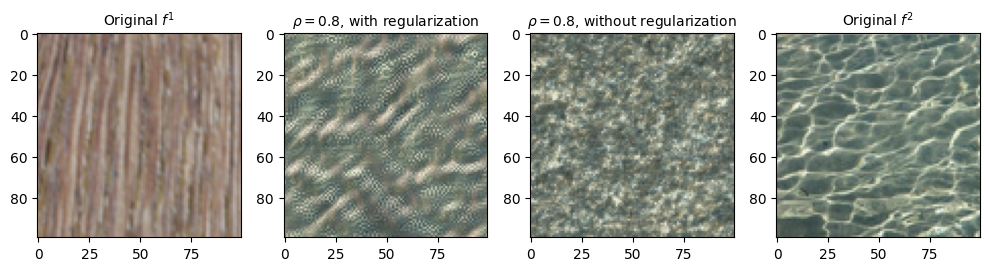

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(textures[0])
plt.title('Original $f^1$', fontsize=10)
plt.subplot(1,4,2)
plt.imshow(synthesis_with_reg_1)
plt.title(r'$\rho = {}$, with regularization'.format(rho[0]), fontsize=10)
plt.subplot(1,4,3)
plt.imshow(synthesis_without_reg_1)
plt.title(r'$\rho = {}$, without regularization'.format(rho[0]), fontsize=10)
plt.subplot(1,4,4)
plt.imshow(textures[1])
plt.title('Original $f^2$', fontsize=10)
plt.tight_layout()

In [ ]:
# synthesis_with_reg = []
# synthesis_without_reg = []
# RHO = [0.2, 0.5, 0.8]
# for r in RHO:
#     synthesis_without_reg.append(compute_texture_mixing(textures, [1-r, r], num_scales = 4, num_orientations = 4, n_iter = 10))
#     synthesis_with_reg.append(compute_texture_mixing_with_reg(textures, [1-r, r], num_scales = 4, num_orientations = 4, n_iter = 10))










100%|██████████| 18/18 [00:13<00:00,  1.38it/s]








100%|██████████| 18/18 [04:59<00:00, 16.62s/it]










100%|██████████| 18/18 [00:13<00:00,  1.34it/s]








100%|██████████| 18/18 [05:35<00:00, 18.65s/it]








100%|██████████| 18/18 [00:12<00:00,  1.41it/s]








100%|██████████| 18/18 [04:44<00:00, 15.81s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


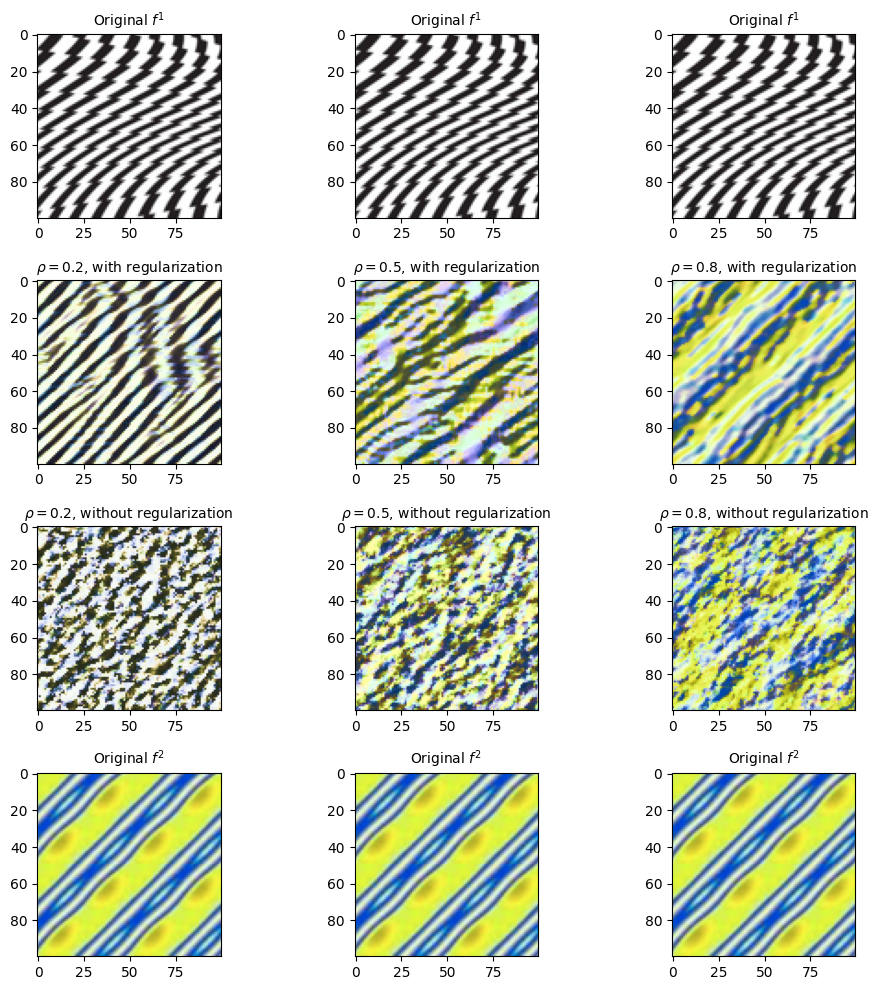

In [115]:
plt.figure(figsize=(10,10))
plt.subplot(4,3,1)
plt.imshow(textures[0])
plt.title('Original $f^1$', fontsize=10)
plt.subplot(4,3,2)
plt.imshow(textures[0])
plt.title('Original $f^1$', fontsize=10)
plt.subplot(4,3,3)
plt.imshow(textures[0])
plt.title('Original $f^1$', fontsize=10)
plt.subplot(4,3,4)
plt.imshow(synthesis_with_reg_3)
plt.title(r'$\rho = {}$, with regularization'.format(0.2), fontsize=10)
plt.subplot(4,3,5)
plt.imshow(synthesis_with_reg_2)
plt.title(r'$\rho = {}$, with regularization'.format(0.5), fontsize=10)
plt.subplot(4,3,6)
plt.imshow(synthesis_with_reg_1) #synthesis_with_reg_1
plt.title(r'$\rho = {}$, with regularization'.format(0.8), fontsize=10)


plt.subplot(4,3,7)
plt.imshow(synthesis_without_reg_3)
plt.title(r'$\rho = {}$, without regularization'.format(0.2), fontsize=10)
plt.subplot(4,3,8)
plt.imshow(synthesis_without_reg_2)
plt.title(r'$\rho = {}$, without regularization'.format(0.5), fontsize=10)
plt.subplot(4,3,9)
plt.imshow(synthesis_without_reg_1)
plt.title(r'$\rho = {}$, without regularization'.format(0.8), fontsize=10)

plt.subplot(4,3,10)
plt.imshow(textures[1])
plt.title('Original $f^2$', fontsize=10)
plt.subplot(4,3,11)
plt.imshow(textures[1])
plt.title('Original $f^2$', fontsize=10)
plt.subplot(4,3,12)
plt.imshow(textures[1])
plt.title('Original $f^2$', fontsize=10)
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


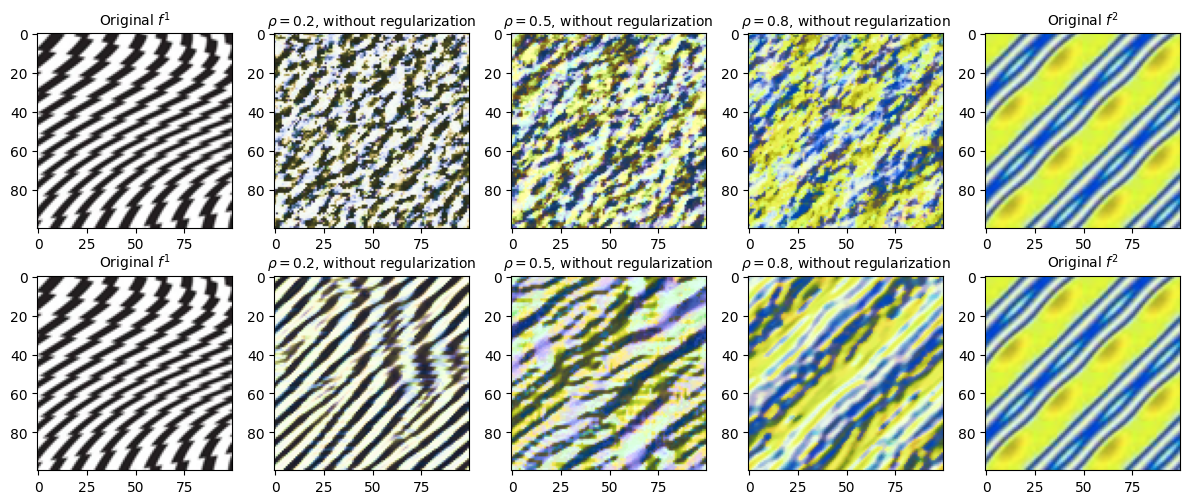

In [114]:
plt.figure(figsize=(12,5))
plt.subplot(2,5,1)
plt.imshow(textures[0])
plt.title('Original $f^1$', fontsize=10)
plt.subplot(2,5,2)
plt.imshow(synthesis_without_reg_3)
plt.title(r'$\rho = {}$, without regularization'.format(0.2), fontsize=10)
plt.subplot(2,5,3)
plt.imshow(synthesis_without_reg_2)
plt.title(r'$\rho = {}$, without regularization'.format(0.5), fontsize=10)
plt.subplot(2,5,4)
plt.imshow(synthesis_without_reg_1)
plt.title(r'$\rho = {}$, without regularization'.format(0.8), fontsize=10)
plt.subplot(2,5,5)
plt.imshow(textures[1])
plt.title('Original $f^2$', fontsize=10)

plt.subplot(2,5,6)
plt.imshow(textures[0])
plt.title('Original $f^1$', fontsize=10)
plt.subplot(2,5,7)
plt.imshow(synthesis_with_reg_3)
plt.title(r'$\rho = {}$, without regularization'.format(0.2), fontsize=10)
plt.subplot(2,5,8)
plt.imshow(synthesis_with_reg_2)
plt.title(r'$\rho = {}$, without regularization'.format(0.5), fontsize=10)
plt.subplot(2,5,9)
plt.imshow(synthesis_with_reg_1) #synthesis_with_reg_1
plt.title(r'$\rho = {}$, without regularization'.format(0.8), fontsize=10)
plt.subplot(2,5,10)
plt.imshow(textures[1])
plt.title('Original $f^2$', fontsize=10)
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


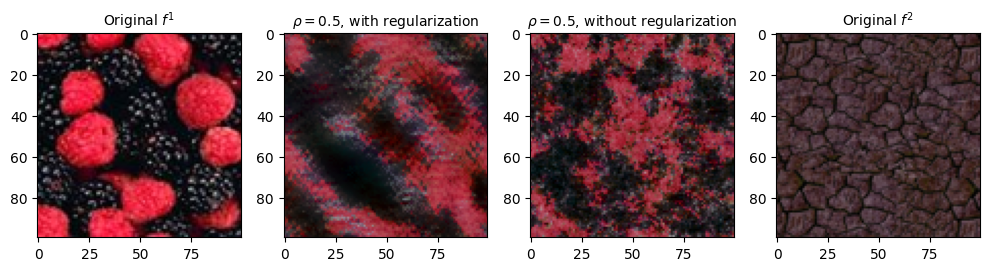

In [53]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(textures[0])
plt.title('Original $f^1$', fontsize=10)
plt.subplot(1,4,2)
plt.imshow(synthesis_with_reg)
plt.title(r'$\rho = {}$, with regularization'.format(rho[0]), fontsize=10)
plt.subplot(1,4,3)
plt.imshow(synthesis_without_reg)
plt.title(r'$\rho = {}$, without regularization'.format(rho[0]), fontsize=10)
plt.subplot(1,4,4)
plt.imshow(textures[1])
plt.title('Original $f^2$', fontsize=10)
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


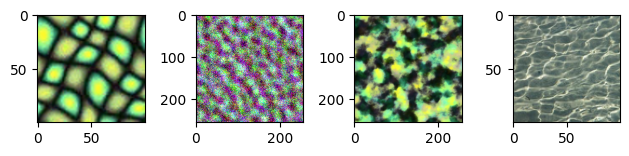

In [174]:
plt.subplot(1,4,1)
plt.imshow(textures[0])
plt.subplot(1,4,2)
plt.imshow(synthesis_with_reg)
plt.subplot(1,4,3)
plt.imshow(synthesis_without_reg)
plt.subplot(1,4,4)
plt.imshow(textures[1])
plt.tight_layout()